In [25]:
# import all required packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

In [26]:
sns.set(style='whitegrid')
OUT_DIR = "nsl_kdd_outputs_v2"
PLOTS_DIR = os.path.join(OUT_DIR, "plots")
MODELS_DIR = os.path.join(OUT_DIR, "models")
REPORTS_DIR = os.path.join(OUT_DIR, "reports")
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)

In [27]:
# Function to save and show the plots at same time
def save_show(fig=None, name='plot.png', dpi=150, show=True):
    """Save current plt figure (or provided fig) and optionally show it."""
    path = os.path.join(PLOTS_DIR, name)
    if fig is None:
        plt.tight_layout()
        plt.savefig(path, dpi=dpi)
        if show:
            plt.show()
        plt.close()
    else:
        fig.tight_layout()
        fig.savefig(path, dpi=dpi)
        if show:
            plt.show()
        plt.close(fig)
    print("Saved:", path)


In [28]:
# Load data
# -------------------------
print("Loading dataset ...")
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print("Train shape:", train_df.shape, "Test shape:", test_df.shape)
train_df.head()

Loading dataset ...
Train shape: (151165, 42) Test shape: (34394, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [29]:
train_df.groupby('class').count()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
class,,,,,,,,,,,,,,,,,,,,,
anomaly,70373,70373,70373,70373,70373,70373,70373,70373,70373,70373,...,70373,70373,70373,70373,70373,70373,70373,70373,70373,70373
normal,80792,80792,80792,80792,80792,80792,80792,80792,80792,80792,...,80792,80792,80792,80792,80792,80792,80792,80792,80792,80792


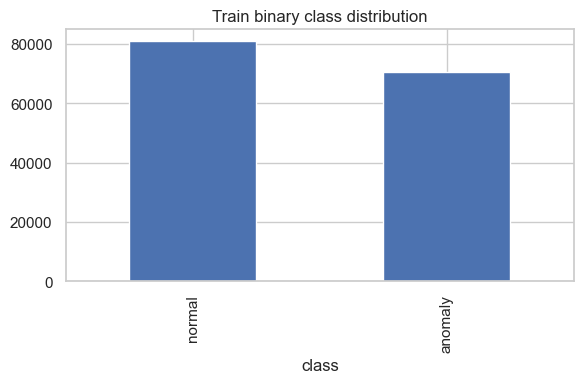

Saved: nsl_kdd_outputs_v2\plots\binary_class_distribution.png


In [30]:
# Class plot
plt.figure(figsize=(6,4))
train_df['class'].value_counts().plot(kind='bar')
plt.title('Train binary class distribution')
save_show(name='binary_class_distribution.png')

In [31]:
train_df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,151165.000000,1.511650e+05,1.511650e+05,151165.000000,151165.000000,151165.000000,151165.000000,151165.000000,151165.000000,151165.000000,...,151165.000000,151165.000000,151165.000000,151165.000000,151165.000000,151165.000000,151165.000000,151165.000000,151165.000000,151165.000000
mean,290.129302,4.202769e+04,1.706480e+04,0.000179,0.022862,0.000099,0.203347,0.001217,0.395574,0.270684,...,182.212794,115.554685,0.521000,0.082882,0.148225,0.032426,0.284677,0.278711,0.118660,0.119995
std,2618.365506,5.448522e+06,3.671113e+06,0.013363,0.254657,0.013364,2.150669,0.045269,0.488975,22.266054,...,99.170637,110.693281,0.448947,0.188634,0.308891,0.112235,0.444872,0.445736,0.306442,0.319106
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,62.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.760000e+02,5.200000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151165 entries, 0 to 151164
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     151165 non-null  int64  
 1   protocol_type                151165 non-null  object 
 2   service                      151165 non-null  object 
 3   flag                         151165 non-null  object 
 4   src_bytes                    151165 non-null  int64  
 5   dst_bytes                    151165 non-null  int64  
 6   land                         151165 non-null  int64  
 7   wrong_fragment               151165 non-null  int64  
 8   urgent                       151165 non-null  int64  
 9   hot                          151165 non-null  int64  
 10  num_failed_logins            151165 non-null  int64  
 11  logged_in                    151165 non-null  int64  
 12  num_compromised              151165 non-null  int64  
 13 

In [33]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34394 entries, 0 to 34393
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     34394 non-null  int64  
 1   protocol_type                34394 non-null  object 
 2   service                      34394 non-null  object 
 3   flag                         34394 non-null  object 
 4   src_bytes                    34394 non-null  int64  
 5   dst_bytes                    34394 non-null  int64  
 6   land                         34394 non-null  int64  
 7   wrong_fragment               34394 non-null  int64  
 8   urgent                       34394 non-null  int64  
 9   hot                          34394 non-null  int64  
 10  num_failed_logins            34394 non-null  int64  
 11  logged_in                    34394 non-null  int64  
 12  num_compromised              34394 non-null  int64  
 13  root_shell      

In [56]:
DROP_COLS = ['class']

numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = train_df.select_dtypes(include=['object', 'string']).columns.tolist()

# Remove drop cols from lists if present
numeric_cols = [c for c in numeric_cols if c not in DROP_COLS]
cat_cols = [c for c in cat_cols if c not in DROP_COLS]

print("Numeric:\n", numeric_cols, "... total:", len(numeric_cols))
print("\nCategorical:", cat_cols, "... total:", len(cat_cols))

Numeric:
 ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'] ... total: 38

Categorical: ['protocol_type', 'service', 'flag'] ... total: 3


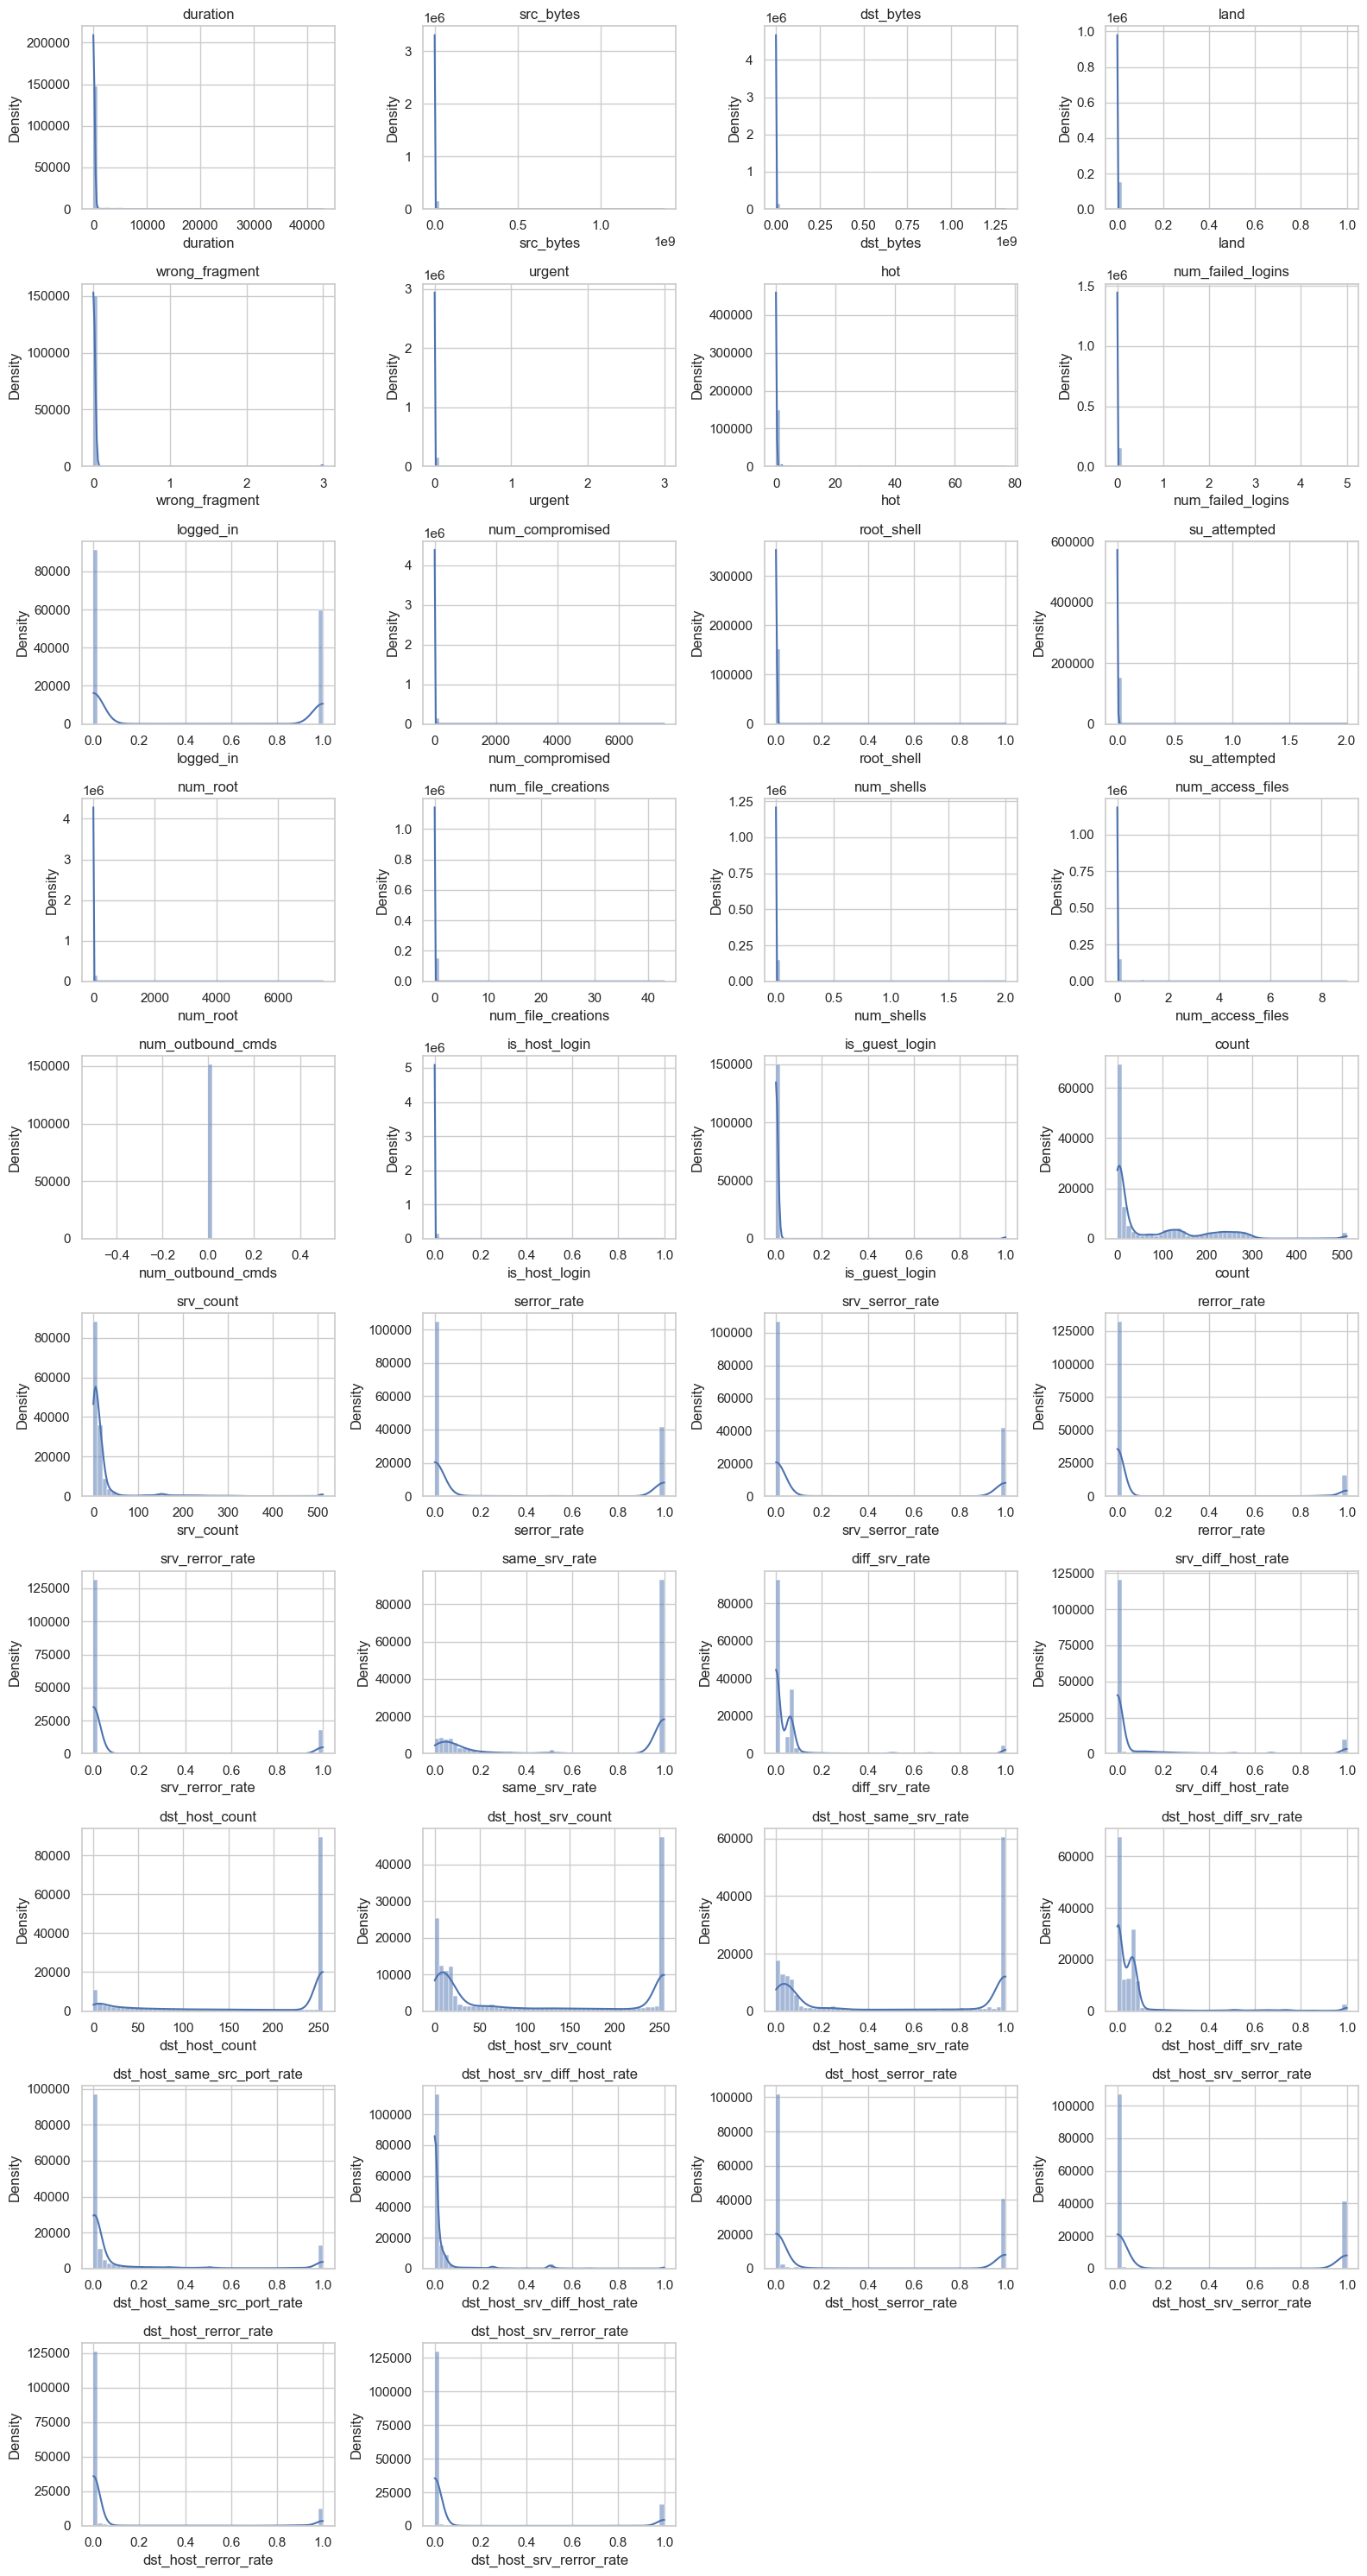

Saved: nsl_kdd_outputs_v2\plots\All_col_hist.png


In [59]:
import math

cols = 4   # number of plots per row
n = len(numeric_cols)
rows = math.ceil(n / cols)

plt.figure(figsize=(cols * 4, rows * 3))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(train_df[col].dropna(), bins=50, kde=True)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Density")

plt.tight_layout()
save_show(name=f"All_col_hist.png")

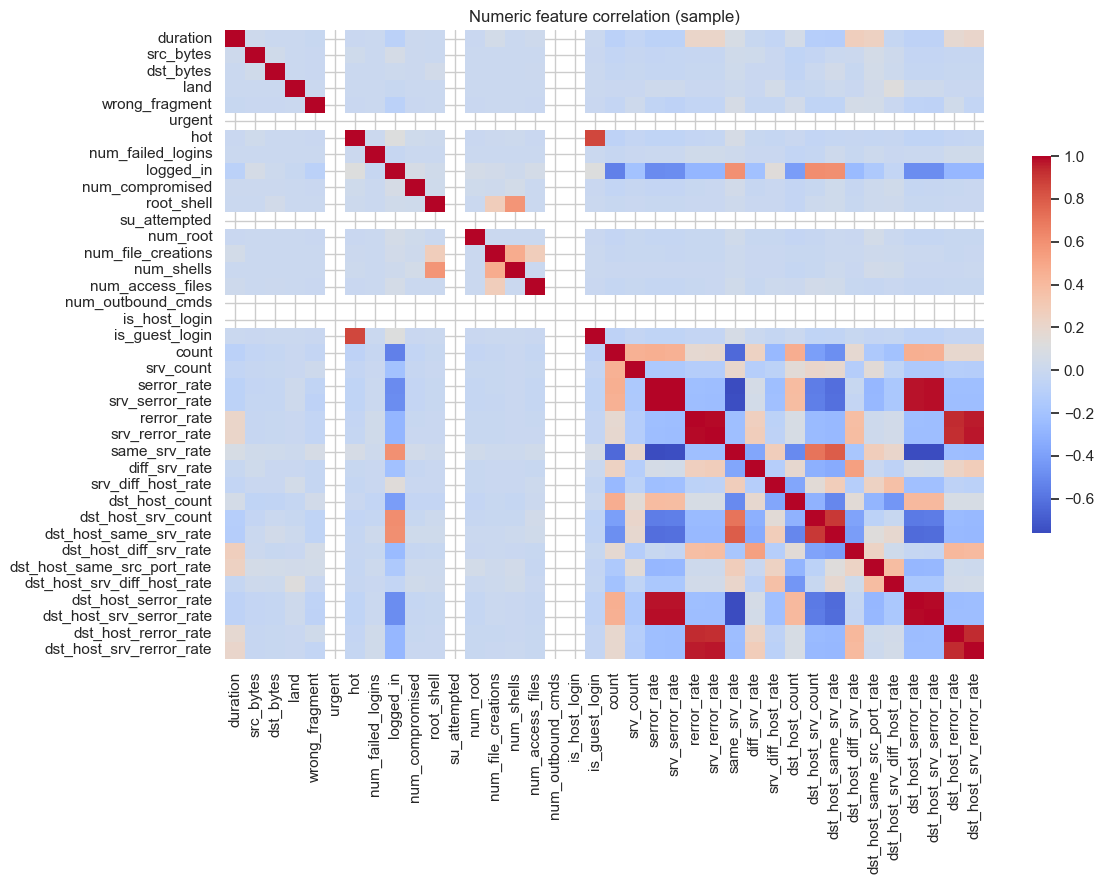

Saved: nsl_kdd_outputs_v2\plots\correlation_heatmap.png


In [36]:
try:
    sample_corr = train_df[numeric_cols].sample(min(5000, len(train_df)), random_state=42)
    fig, ax = plt.subplots(figsize=(12,9))
    sns.heatmap(sample_corr.corr(), cmap='coolwarm', ax=ax, cbar_kws={'shrink':0.6})
    plt.title('Numeric feature correlation (sample)')
    save_show(fig, 'correlation_heatmap.png')
except Exception as e:
    print("Could not draw correlation plot:", e)


In [37]:
corr_matrix = train_df[numeric_cols].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find columns to drop
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

print("Highly correlated — drop these:", to_drop)

# Final selected features
selected_features = [c for c in numeric_cols if c not in to_drop]
print("\nSelected numeric features:", selected_features)

Highly correlated — drop these: ['num_root', 'is_guest_login', 'srv_serror_rate', 'srv_rerror_rate', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

Selected numeric features: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'count', 'srv_count', 'serror_rate', 'rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate']


In [38]:
skew_values = train_df[selected_features].skew().sort_values(ascending=False)
print(skew_values)

is_host_login                  388.799434
dst_bytes                      317.688223
num_compromised                260.185040
src_bytes                      201.003035
urgent                         157.955159
land                            74.805180
num_shells                      59.115231
num_file_creations              55.035713
num_failed_logins               53.688017
num_access_files                44.934962
su_attempted                    41.641058
root_shell                      26.902984
hot                             12.757143
duration                        11.820065
wrong_fragment                  11.410934
dst_host_srv_diff_host_rate      5.559507
srv_count                        4.696335
diff_srv_rate                    4.386046
dst_host_diff_srv_rate           3.610714
srv_diff_host_rate               2.864590
rerror_rate                      2.328957
dst_host_same_src_port_rate      2.088926
count                            1.512496
serror_rate                      0

In [39]:
# Skew_values to determine heavy-tailed columns
heavy_tail_feats = skew_values[skew_values > 2.0].index.tolist()

# remaining numeric columns
num_feats_scaled = [c for c in selected_features if c not in heavy_tail_feats]

print("Log-transform:", heavy_tail_feats)
print("\nScale-only:", num_feats_scaled)


Log-transform: ['is_host_login', 'dst_bytes', 'num_compromised', 'src_bytes', 'urgent', 'land', 'num_shells', 'num_file_creations', 'num_failed_logins', 'num_access_files', 'su_attempted', 'root_shell', 'hot', 'duration', 'wrong_fragment', 'dst_host_srv_diff_host_rate', 'srv_count', 'diff_srv_rate', 'dst_host_diff_srv_rate', 'srv_diff_host_rate', 'rerror_rate', 'dst_host_same_src_port_rate']

Scale-only: ['logged_in', 'num_outbound_cmds', 'count', 'serror_rate', 'same_srv_rate', 'dst_host_count', 'dst_host_srv_count']


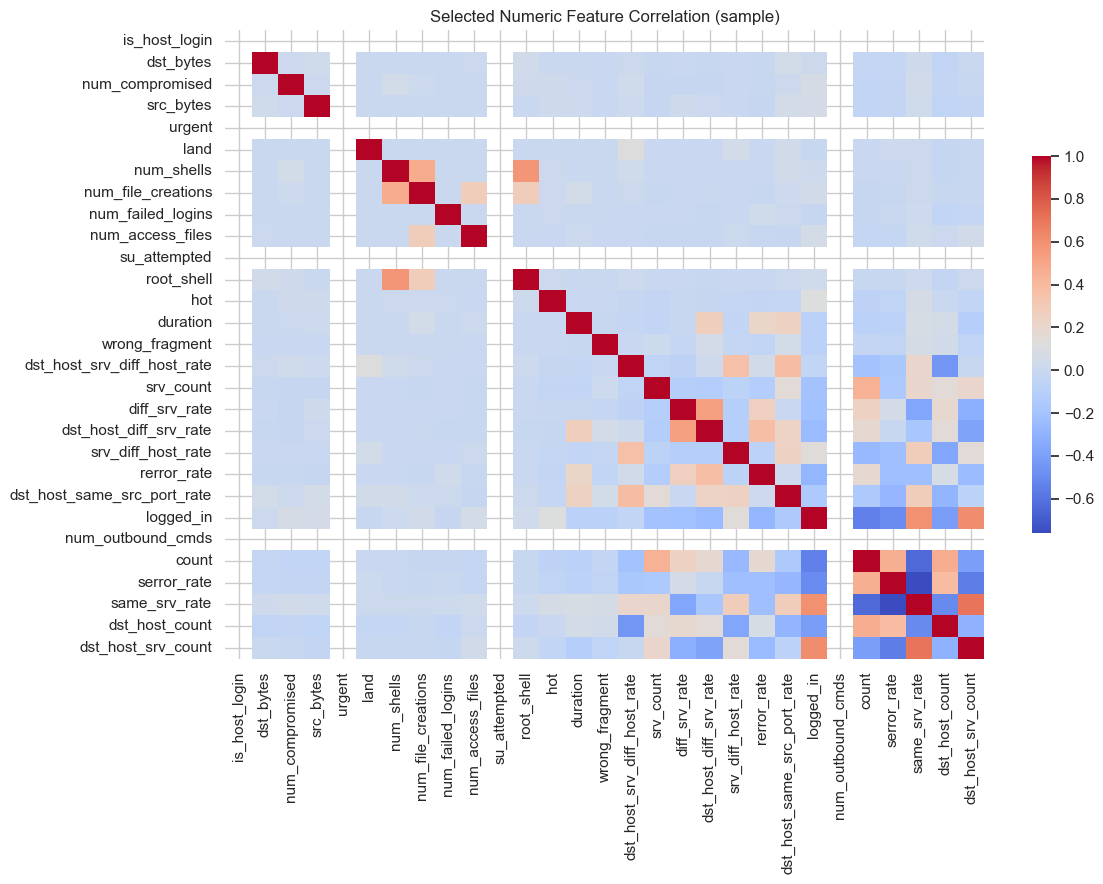

Saved: nsl_kdd_outputs_v2\plots\correlation_heatmap_selected.png


In [41]:
try:
    selected_numeric = heavy_tail_feats + num_feats_scaled

    sample_corr = train_df[selected_numeric].sample(min(5000, len(train_df)), random_state=42)
    fig, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(sample_corr.corr(), cmap='coolwarm', ax=ax, cbar_kws={'shrink': 0.6})
    plt.title('Selected Numeric Feature Correlation (sample)')
    save_show(fig, 'correlation_heatmap_selected.png')

except Exception as e:
    print("Could not draw correlation plot:", e)


In [42]:
log_transformer = Pipeline([
    ('log1p', FunctionTransformer(np.log1p, validate=False)),
    ('scale', StandardScaler())
])

# ColumnTransformer: apply log_transformer for heavy tail, scale others, one-hot encode cats
preprocessor = ColumnTransformer(
    transformers=[
        ('lognum', log_transformer, heavy_tail_feats),
        ('scale', StandardScaler(), num_feats_scaled),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

In [49]:
# From 
X_train = train_df.drop(columns=DROP_COLS)
y_train = train_df['class'].values
X_test = test_df.drop(columns=DROP_COLS)
y_test = test_df['class'].values

# From the above EDA we can see there are no NULL / NaN values in any column, below is loop to replace null values with median 
# # If there are NaNs in numeric -> fill with median (safe)
# for col in (heavy_tail_feats + num_feats_scaled):
#     if X_train[col].isnull().any():
#         med = X_train[col].median()
#         X_train[col].fillna(med, inplace=True)
#         X_test[col].fillna(med, inplace=True)


In [44]:
# -------------------------
# Build models (list)
# -------------------------
models = {
    'decision_tree': DecisionTreeClassifier(max_depth=10, class_weight='balanced', random_state=42),
    'random_forest': RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight='balanced', random_state=42),
    'logreg': LogisticRegression(max_iter=200, class_weight='balanced', n_jobs=-1)
}


--- Training: decision_tree ---
decision_tree accuracy: 0.7098
              precision    recall  f1-score   support

     anomaly     0.9602    0.5811    0.7241     22531
      normal     0.5454    0.9543    0.6941     11863

    accuracy                         0.7098     34394
   macro avg     0.7528    0.7677    0.7091     34394
weighted avg     0.8171    0.7098    0.7137     34394

Saved model to: nsl_kdd_outputs_v2\models\decision_tree_pipeline.joblib


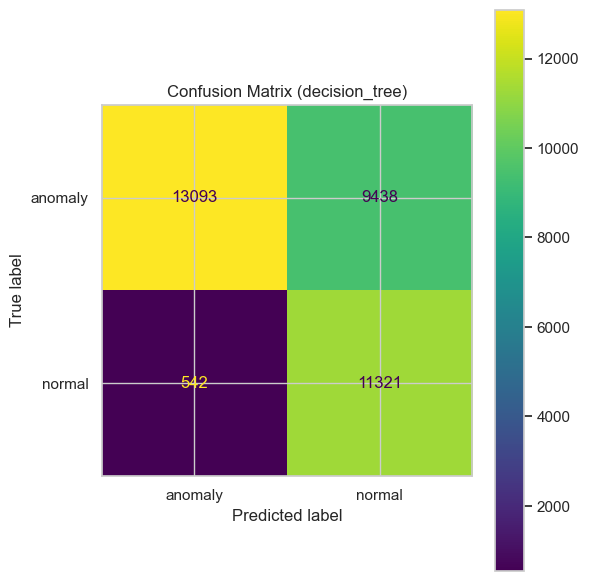

Saved: nsl_kdd_outputs_v2\plots\confusion_matrix_decision_tree.png
Saved report for decision_tree
Could not compute feature importances plot: Estimator log1p does not provide get_feature_names_out. Did you mean to call pipeline[:-1].get_feature_names_out()?

--- Training: random_forest ---
random_forest accuracy: 0.7114
              precision    recall  f1-score   support

     anomaly     0.9619    0.5825    0.7256     22531
      normal     0.5467    0.9562    0.6956     11863

    accuracy                         0.7114     34394
   macro avg     0.7543    0.7693    0.7106     34394
weighted avg     0.8187    0.7114    0.7153     34394

Saved model to: nsl_kdd_outputs_v2\models\random_forest_pipeline.joblib


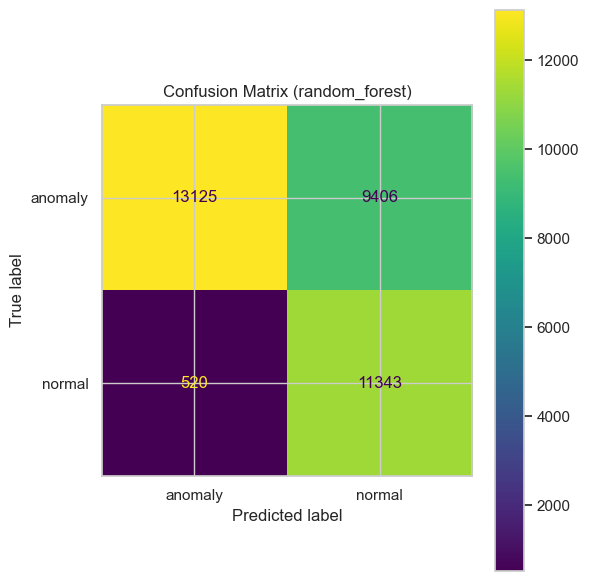

Saved: nsl_kdd_outputs_v2\plots\confusion_matrix_random_forest.png
Saved report for random_forest
Could not compute feature importances plot: Estimator log1p does not provide get_feature_names_out. Did you mean to call pipeline[:-1].get_feature_names_out()?

--- Training: logreg ---
logreg accuracy: 0.6738
              precision    recall  f1-score   support

     anomaly     0.8975    0.5668    0.6948     22531
      normal     0.5160    0.8771    0.6497     11863

    accuracy                         0.6738     34394
   macro avg     0.7068    0.7220    0.6723     34394
weighted avg     0.7659    0.6738    0.6793     34394

Saved model to: nsl_kdd_outputs_v2\models\logreg_pipeline.joblib


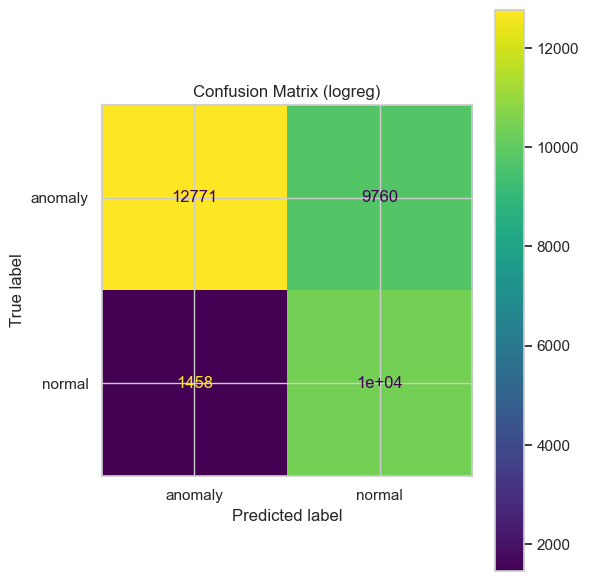

Saved: nsl_kdd_outputs_v2\plots\confusion_matrix_logreg.png
Saved report for logreg


In [48]:
results = {}

for name, clf in models.items():
    print("\n--- Training:", name, "---")

    # Build pipeline: preprocessor -> classifier (NO SMOTE)
    pipe = Pipeline([
        ('preproc', preprocessor),
        ('clf', clf)
    ])

    # Fit
    pipe.fit(X_train, y_train)

    # Predict & evaluate
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, digits=4))

    # store results
    results[name] = {'pipeline': pipe, 'y_pred': y_pred, 'accuracy': acc}

    # Save model pipeline
    model_path = os.path.join(MODELS_DIR, f"{name}_pipeline.joblib")
    joblib.dump(pipe, model_path)
    print("Saved model to:", model_path)

    # Confusion matrix (use labels present in y_test to be robust)
    labels = list(np.unique(y_test))
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, cmap='viridis')
    plt.title(f'Confusion Matrix ({name})')
    save_show(fig, f'confusion_matrix_{name}.png')

    # Save classification report to text file
    rep_txt = classification_report(y_test, y_pred, digits=4)
    with open(os.path.join(REPORTS_DIR, f"classification_report_{name}.txt"), 'w') as fh:
        fh.write(f"Model: {name}\nAccuracy: {acc:.4f}\n\n")
        fh.write(rep_txt)
    print("Saved report for", name)

    # Feature importances for tree-based models
    if name in ('decision_tree', 'random_forest'):
        try:
            # feature names after preprocessing
            ft_names = pipe.named_steps['preproc'].get_feature_names_out()
            # get importances from fitted estimator
            clf_fitted = pipe.named_steps['clf']
            if hasattr(clf_fitted, 'feature_importances_'):
                importances = clf_fitted.feature_importances_
            else:
                importances = None

            if importances is not None and len(importances) == len(ft_names):
                fi = pd.Series(importances, index=ft_names).sort_values(ascending=False).head(30)
                fig, ax = plt.subplots(figsize=(12,5))
                fi.plot(kind='bar', ax=ax)
                plt.title(f"Top features ({name})")
                save_show(fig, f"feature_importances_{name}.png")
                fi.to_csv(os.path.join(REPORTS_DIR, f"feature_importances_{name}.csv"))
            else:
                print("Warning: feature importances shape mismatch or not available.")
        except Exception as e:
            print("Could not compute feature importances plot:", e)


In [46]:
# -------------------------
# Compare results summary
# -------------------------
summary = pd.DataFrame([
    {'model': k, 'accuracy': v['accuracy']} for k,v in results.items()
]).sort_values('accuracy', ascending=False).reset_index(drop=True)
print("\nModel comparison:\n", summary)
summary.to_csv(os.path.join(REPORTS_DIR, 'model_comparison.csv'), index=False)
save_show(name='final_model_comparison.png')  # will save the last figure (if any)


Model comparison:
            model  accuracy
0  random_forest  0.711403
1  decision_tree  0.709833
2         logreg  0.673838


<Figure size 640x480 with 0 Axes>

Saved: nsl_kdd_outputs_v2\plots\final_model_comparison.png
